In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'weather-dataset-rattle-package:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F6012%2F1733506%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240527%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240527T000822Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D5c3f3bfa1cc6516cb6ec46ee5f3765b6cda67e33eb319ef15aa6848381344154693ef4d324206765abdfe1d1831428267c78dc0b327e525aec8cc145dd531fe45ef114686dfc0c5ca6f95c96242876506e5adbac7d464d39e0e353db57b784e8c39d57b551c8a6a721d9f8f78d3baa83fc2442d4a809b68711ca6ea095fb6274018c6c7d1a6ef33d14b5da21744b162fd9444cb1a476a072520925ecde956e5ce667be192c701288a6c7c6d35931bf8b833094e7260c55abafceaced28b34dca23232914f2ba2125043ac5c862230bc0bc00e584e2a6193453444af5be97ec1aa7a3f6b9856955e85c397c8c948af903f402ed1e82a65893568297144253a2ce'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 4020790 bytes downloaded
Downloaded and uncompressed: weather-dataset-rattle-package
Data source import complete.


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from scipy import stats

df = pd.read_csv('/kaggle/input/weather-dataset-rattle-package/weatherAUS.csv')

In [3]:
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


# Exploratory Data Analysis

### Dataframe Information

* There are categorical (object) and numerical (float64) features.
* There are missing values.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

## Categorical Features

* There are missing values for WindGustDir, WindDir9am, WindDir3pm, RainToday and Rain Tomorrow. These missing values reprents till 7% of the total data for some features.
* Date and Location do not have any missing values.
* In the next steps we will present a univariate analysis for each feature.

In [5]:
Categorical = list(df.select_dtypes(['object']).columns)

round((df[Categorical].isnull().sum() / df.shape[0]) * 100,2)

Date            0.00
Location        0.00
WindGustDir     7.10
WindDir9am      7.26
WindDir3pm      2.91
RainToday       2.24
RainTomorrow    2.25
dtype: float64

### Date

* In first place, we change Date feature dtype to datetime.
* We extract only the day and month from the Date feature, in order to predict based on the seasons.  

In [6]:
df['Date'] = pd.to_datetime(df['Date']) # Convert Date values to datetime

In [7]:
# Count values frequency
Date = df['Date'].value_counts()

Date.transpose()

Date
2013-11-12    49
2014-09-01    49
2014-08-23    49
2014-08-24    49
2014-08-25    49
              ..
2007-11-29     1
2007-11-28     1
2007-11-27     1
2007-11-26     1
2008-01-31     1
Name: count, Length: 3436, dtype: int64

In [8]:
# Extract the month and day of the Date feature
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day

Text(0, 0.5, 'Counts')

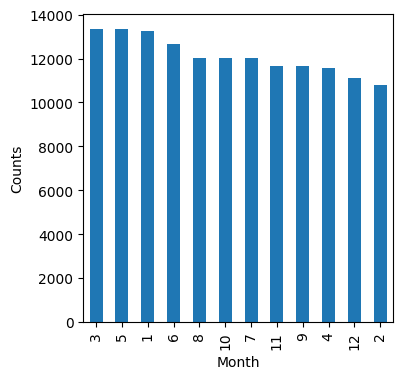

In [9]:
# Plot Month frequency
Month = df['Month'].value_counts()
ax = Month.plot.bar(figsize = (4,4), label = False)

ax.set_xlabel('Month')
ax.set_ylabel('Counts')

Text(0, 0.5, 'Counts')

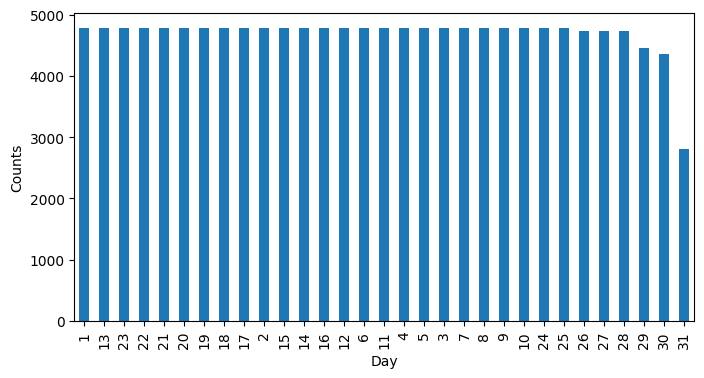

In [10]:
# Plot day frequency
Day = df['Day'].value_counts()
ax = Day.plot.bar(figsize = (8,4), label = False)

ax.set_xlabel('Day')
ax.set_ylabel('Counts')

### Location

* There are 49 different locations.
* The location with more appereance is Canbera with 3436.
* There are not missing values.

In [11]:
print('Total Locations: ', len(df['Location'].unique())) # Total Locations

Total Locations:  49


Text(0.5, 0, 'Location')

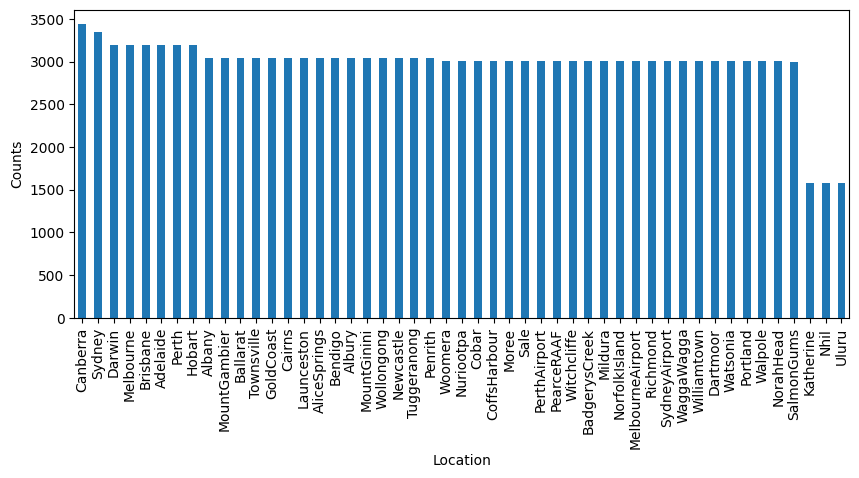

In [12]:
# Plot location frequency
location = df['Location'].value_counts()

ax = location.transpose().plot.bar(figsize = (10,4), legend = False)
ax.set_ylabel('Counts')
ax.set_xlabel('Location')

### WindGustDir  

* The wind can take 16 different directions.
* There are missing values, 10326 in total.
* The wind direction with more appereance is W, with 9915.

In [13]:
print('Total WindGustDir: ', len(df['WindGustDir'].unique())) # Total WindGustDir

Total WindGustDir:  17


In [14]:
df['WindGustDir'].isnull().sum() # Total NULL values

10326

Text(0.5, 0, 'WindGustDir')

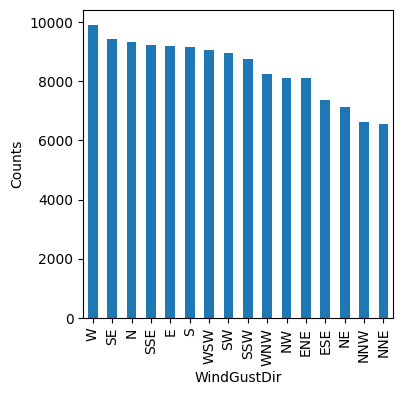

In [15]:
# Plot WindGustDir frequency
WindGustDir = df['WindGustDir'].value_counts()

ax = WindGustDir.transpose().plot.bar(figsize = (4,4), legend = False)
ax.set_ylabel('Counts')
ax.set_xlabel('WindGustDir')

### WindDir9am

* There are 10566 missing values for the WindDir9am feature.
* The WindDir9am value with most appereance is N, a different direction compare to the WindGustDir feature.

In [16]:
print('Total WindDir9am: ', len(df['WindDir9am'].unique())) # Total WindDir9am

Total WindDir9am:  17


In [17]:
df['WindDir9am'].isnull().sum() # Total NULL values

10566

Text(0.5, 0, 'WindDir9am')

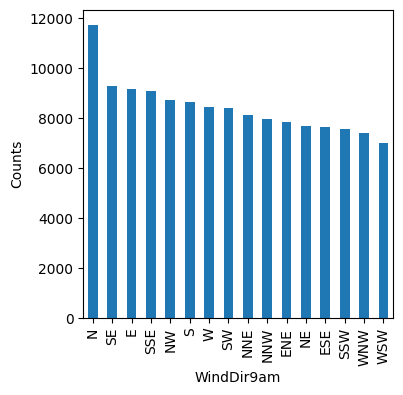

In [18]:
# Plot WindDir9am frequency
WindDir9am = df['WindDir9am'].value_counts()

ax = WindDir9am.plot.bar(figsize = (4,4), label = False)
ax.set_ylabel('Counts')
ax.set_xlabel('WindDir9am')

### WindDir3pm

* There are 4228 missing values.
* The WindDir3pm value with most appereance is SE, a different one compare with the previous two wind directions.

In [19]:
df['WindDir3pm'].isnull().sum() # Total NULL WindDir3pm

4228

Text(0, 0.5, 'Counts')

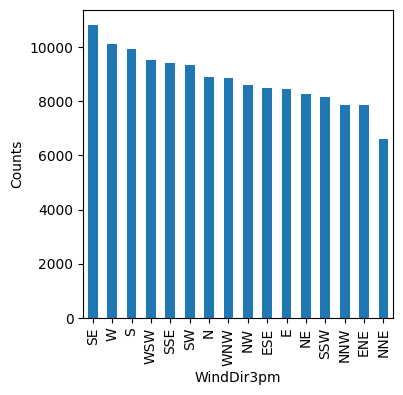

In [20]:
# Plot WindDir3pm frequency
WindDir3pm = df['WindDir3pm'].value_counts()

ax = WindDir3pm.plot.bar(figsize = (4,4), label = False)
ax.set_xlabel('WindDir3pm')
ax.set_ylabel('Counts')

### RainToday

* There are 3261 missing values.
* The most common value is that did not rain today.

In [21]:
df['RainToday'].isnull().sum() # Total Null values

3261

In [22]:
# Value counts
RainToday = df['RainToday'].value_counts()

RainToday.transpose()

RainToday
No     110319
Yes     31880
Name: count, dtype: int64

Text(0.5, 0, 'RainToday')

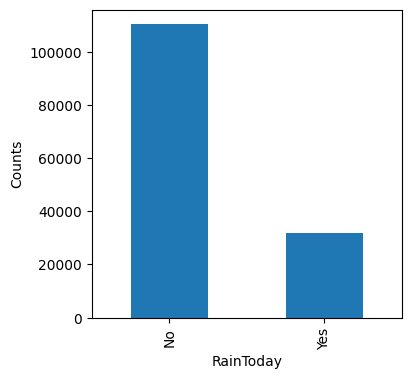

In [23]:
# Plot RainToday frequency
ax = RainToday.plot.bar(figsize = (4,4), label = False)
ax.set_ylabel('Counts')
ax.set_xlabel('RainToday')

### RainTomorrow

* There are 3267 missing values.
* No rain is the most common value.

In [24]:
df['RainTomorrow'].isnull().sum() # Total NULL values

3267

In [25]:
# RainTomorrow value counts
RainTomorrow = df['RainTomorrow'].value_counts()

RainTomorrow.transpose()

RainTomorrow
No     110316
Yes     31877
Name: count, dtype: int64

Text(0, 0.5, 'Counts')

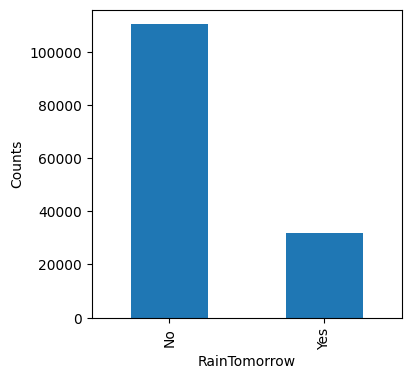

In [26]:
# Plot RainTomorrow frequency
ax = RainTomorrow.plot.bar(figsize = (4,4), label = False)
ax.set_xlabel('RainTomorrow')
ax.set_ylabel('Counts')

### Categorical Data Preprocessing

* We delete the values with missing information about the RainTomorrow feature, because these values only represent the 2.3% of the data.
* On the other hand, we replace the missing values with the mode for the rest of the features.

In [27]:
df = df[df['RainTomorrow'].notnull()] # Drop null data

# Replace Null values with the mode of each feature if it rains or not
for col in Categorical:

  if df[col].isnull().sum() > 0:
    # Mode when it rains tomorrow
    df.loc[(df[col].isnull()) & (df['RainTomorrow'] == 'Yes'), col] = df[df['RainTomorrow'] == 'Yes'][col].mode()[0]

    # Mode when didnt rain tomorrow
    df.loc[(df[col].isnull()) & (df['RainTomorrow'] == 'No'), col] = df[df['RainTomorrow'] == 'No'][col].mode()[0]

In [28]:
Categorical = list(df.select_dtypes(['object']).columns)

round((df[Categorical].isnull().sum() / df.shape[0]) * 100,2)

Location        0.0
WindGustDir     0.0
WindDir9am      0.0
WindDir3pm      0.0
RainToday       0.0
RainTomorrow    0.0
dtype: float64

## Numerical Data

* First of all, we scale the date to compare the different features in the same scale.

* There are missing values for each feature, the missing values goes from 1% for the MaxTemp feature to almots 50% for the Sunshine features.

* We can see that RainFall and Evaporation features have big tails, based in the violin plot. But, at the same time Evaporation present 43% of missing values, so we decided to drop this feture from the data.

* Cloud related features have a high deviation as we can see in the IQR values, besides they have almost 40% of missing values. So we choose to not use these features, aswell, we drop the Sunshine feature with 40% of missing values.

In [29]:
from sklearn.preprocessing import StandardScaler

Numerical = list(df.select_dtypes(['float64']).columns) # Get the numerical features

df_numerical = df[Numerical].copy() # Copy of the original dataframe

# Scaling the numerical features
scaler_ = StandardScaler()
scaler_.fit(df_numerical)
df_numerical = pd.DataFrame(scaler_.transform(df_numerical), columns  = df_numerical.columns)

In [30]:
round((df[Numerical].isnull().sum() / df.shape[0]) * 100,2) # Print the Missing values percentage

MinTemp           0.45
MaxTemp           0.23
Rainfall          0.99
Evaporation      42.79
Sunshine         47.69
WindGustSpeed     6.52
WindSpeed9am      0.95
WindSpeed3pm      1.85
Humidity9am       1.25
Humidity3pm       2.54
Pressure9am       9.86
Pressure3pm       9.83
Cloud9am         37.74
Cloud3pm         40.15
Temp9am           0.64
Temp3pm           1.92
dtype: float64

In [31]:
# Present quantiles of the numerical features
quantiles = []

for col in Numerical:
  quantiles.append(list(df[col].quantile([0.05,0.25, 0.5, 0.75, 0.95]))) # Quantiles for each column

q = [0.05,0.25, 0.5, 0.75, 0.95] # Quantiles

 # Create a dataframe of quantiles
quantiles = pd.DataFrame(quantiles,
                         columns = q)
quantiles['Feature'] = Numerical
quantiles

,0.05,0.25,0.5,0.75,0.95,Feature
0,1.8,7.6,12.0,16.8,23.0,MinTemp
1,12.8,17.9,22.6,28.2,35.5,MaxTemp
2,0.0,0.0,0.0,0.8,13.0,Rainfall
3,1.0,2.6,4.8,7.4,12.0,Evaporation
4,0.3,4.9,8.5,10.6,12.8,Sunshine
5,20.0,31.0,39.0,48.0,65.0,WindGustSpeed
6,0.0,7.0,13.0,19.0,30.0,WindSpeed9am
7,6.0,13.0,19.0,24.0,34.8,WindSpeed3pm
8,34.0,57.0,70.0,83.0,98.0,Humidity9am
9,17.0,37.0,52.0,66.0,88.0,Humidity3pm


In [32]:
from statsmodels import robust

# Calculate the MAD and the IQR for each column
MAD = []
IQR = []

# Def a custom function for MAD
def custom_mad(series):
    median = series.median() # Get the median
    return (series - median).abs().median() # Set the MAD value

# Calculate the IQR and the MAD for each numerical feature
for col in Numerical:
  MAD.append(round(custom_mad(df_numerical[col]),1))
  IQR.append(df_numerical[col].quantile(0.75) - df_numerical[col].quantile(0.25))

# Create a dataframe
Variability = pd.DataFrame(Numerical)
Variability['MAD'] = MAD
Variability['IQR'] = IQR

Variability.transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
MAD,0.7,0.7,0.0,0.6,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,1.0,0.7,0.7,0.7
IQR,1.436768,1.447118,0.094505,1.145992,1.507339,1.251035,1.34933,1.24953,1.364742,1.394385,1.337002,1.364286,2.078283,1.837819,1.432352,1.412599


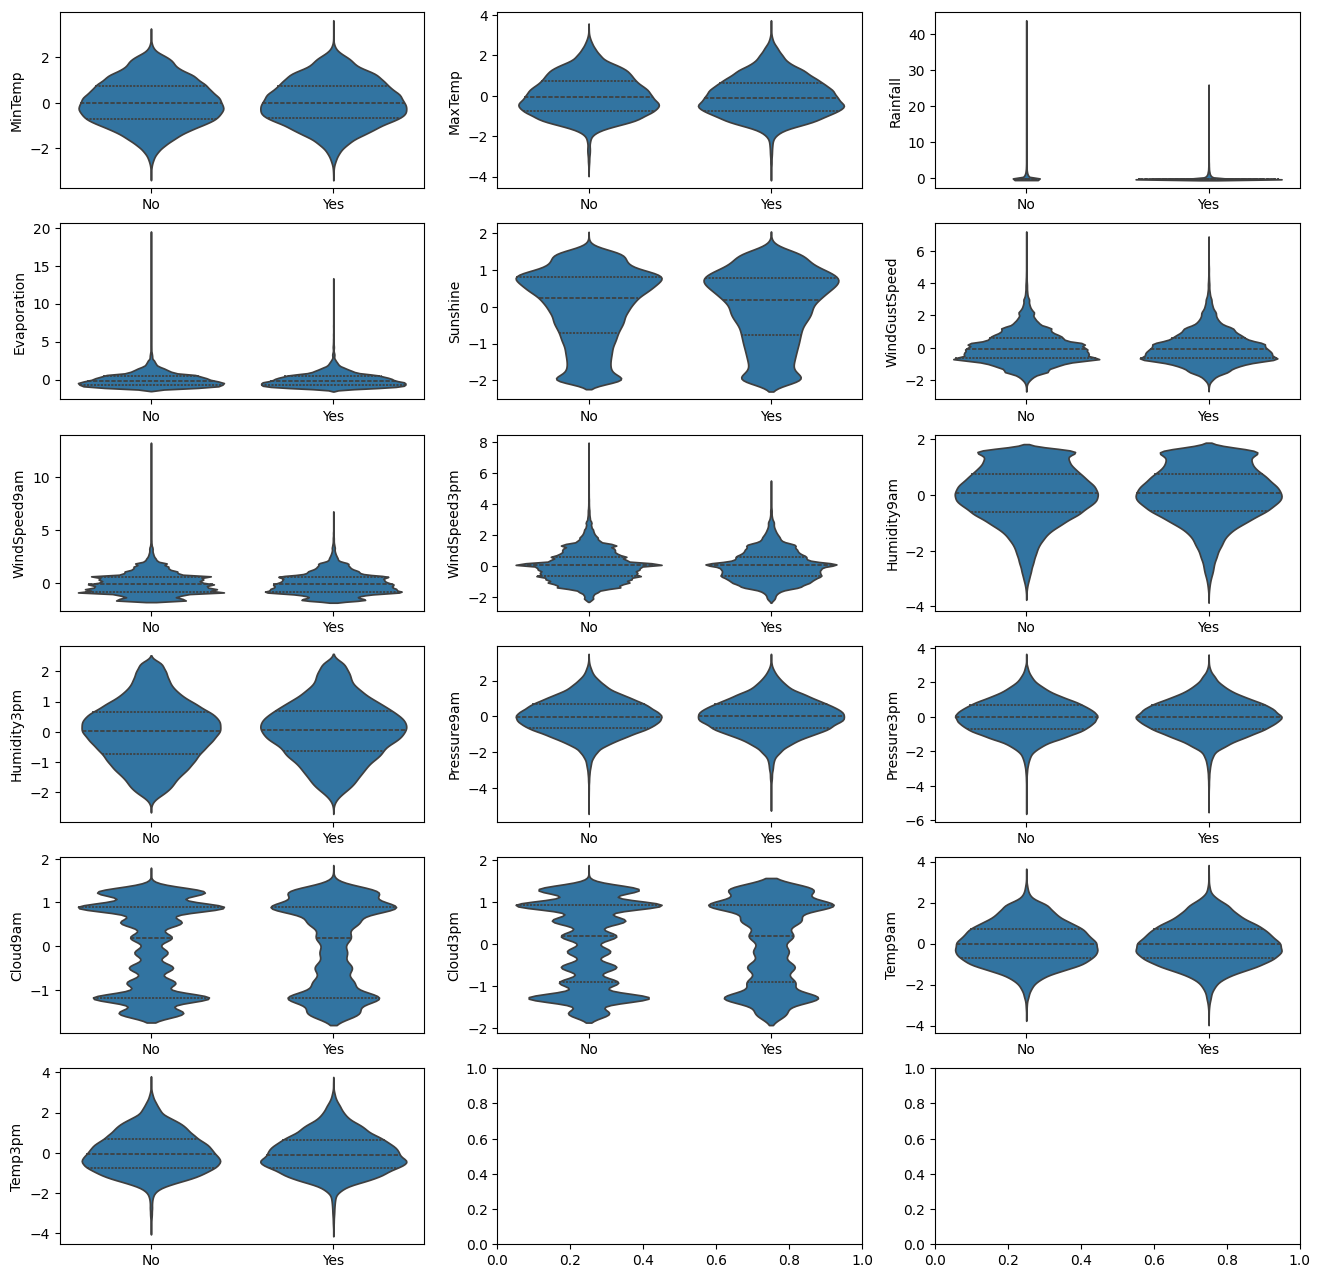

In [33]:
# Violin Plot
list_group = []

# Get package of 3 features to plot the data
for i in range(0, len(Numerical),3):
    list_group.append(Numerical[i:i+3])

fig, axs = plt.subplots(ncols=3, nrows = len(list_group), figsize=(16, 16))

cont = 0

# Loop over the package of features
for pack in list_group:

    for i in range(len(pack)):
        #print(cont,i)
        column = pack[i] # Set the column name

        sns.violinplot(x = df['RainTomorrow'], y = df_numerical[column], inner= 'quartile', ax = axs[cont][i]) # Violing plot over RainTomorrow feature

        # Axis customization
        axs[cont][i].set_xlabel('')
        axs[cont][i].set_ylabel(column)
        #axs[cont][i].set_ylim(df[column].min() - abs(df[column].min()) * 0.1 , df[column].max() + df[column].max() * 0.1)

    cont+=1

In [34]:
# Remove the numerical features that we will not use
Numerical.remove('Evaporation')
Numerical.remove('Cloud9am')
Numerical.remove('Cloud3pm')
Numerical.remove('Sunshine')

### Numerical feature Distribution & Preprocessing.

* We can observer that Rainfall, WindGustspeed and WindSpeed9am features presents distribution similar to a normal distribution, based on the QQplot.

* While the rest of the features tend to present more high and low values than we can expect from a normal distribution.

* Also we can observed that Temp9am, Temp3pm, MaxTemp and MinTemp features, presents similar density plots. Wich give us the idea that they might be highly correlated.

* Features like Rainfall and WindSpeed presents big tails on their density plot, so they have significant outliers.

* Finaly, to fill the missing values we decided to use the median, beacause this measure is robust against outliers.


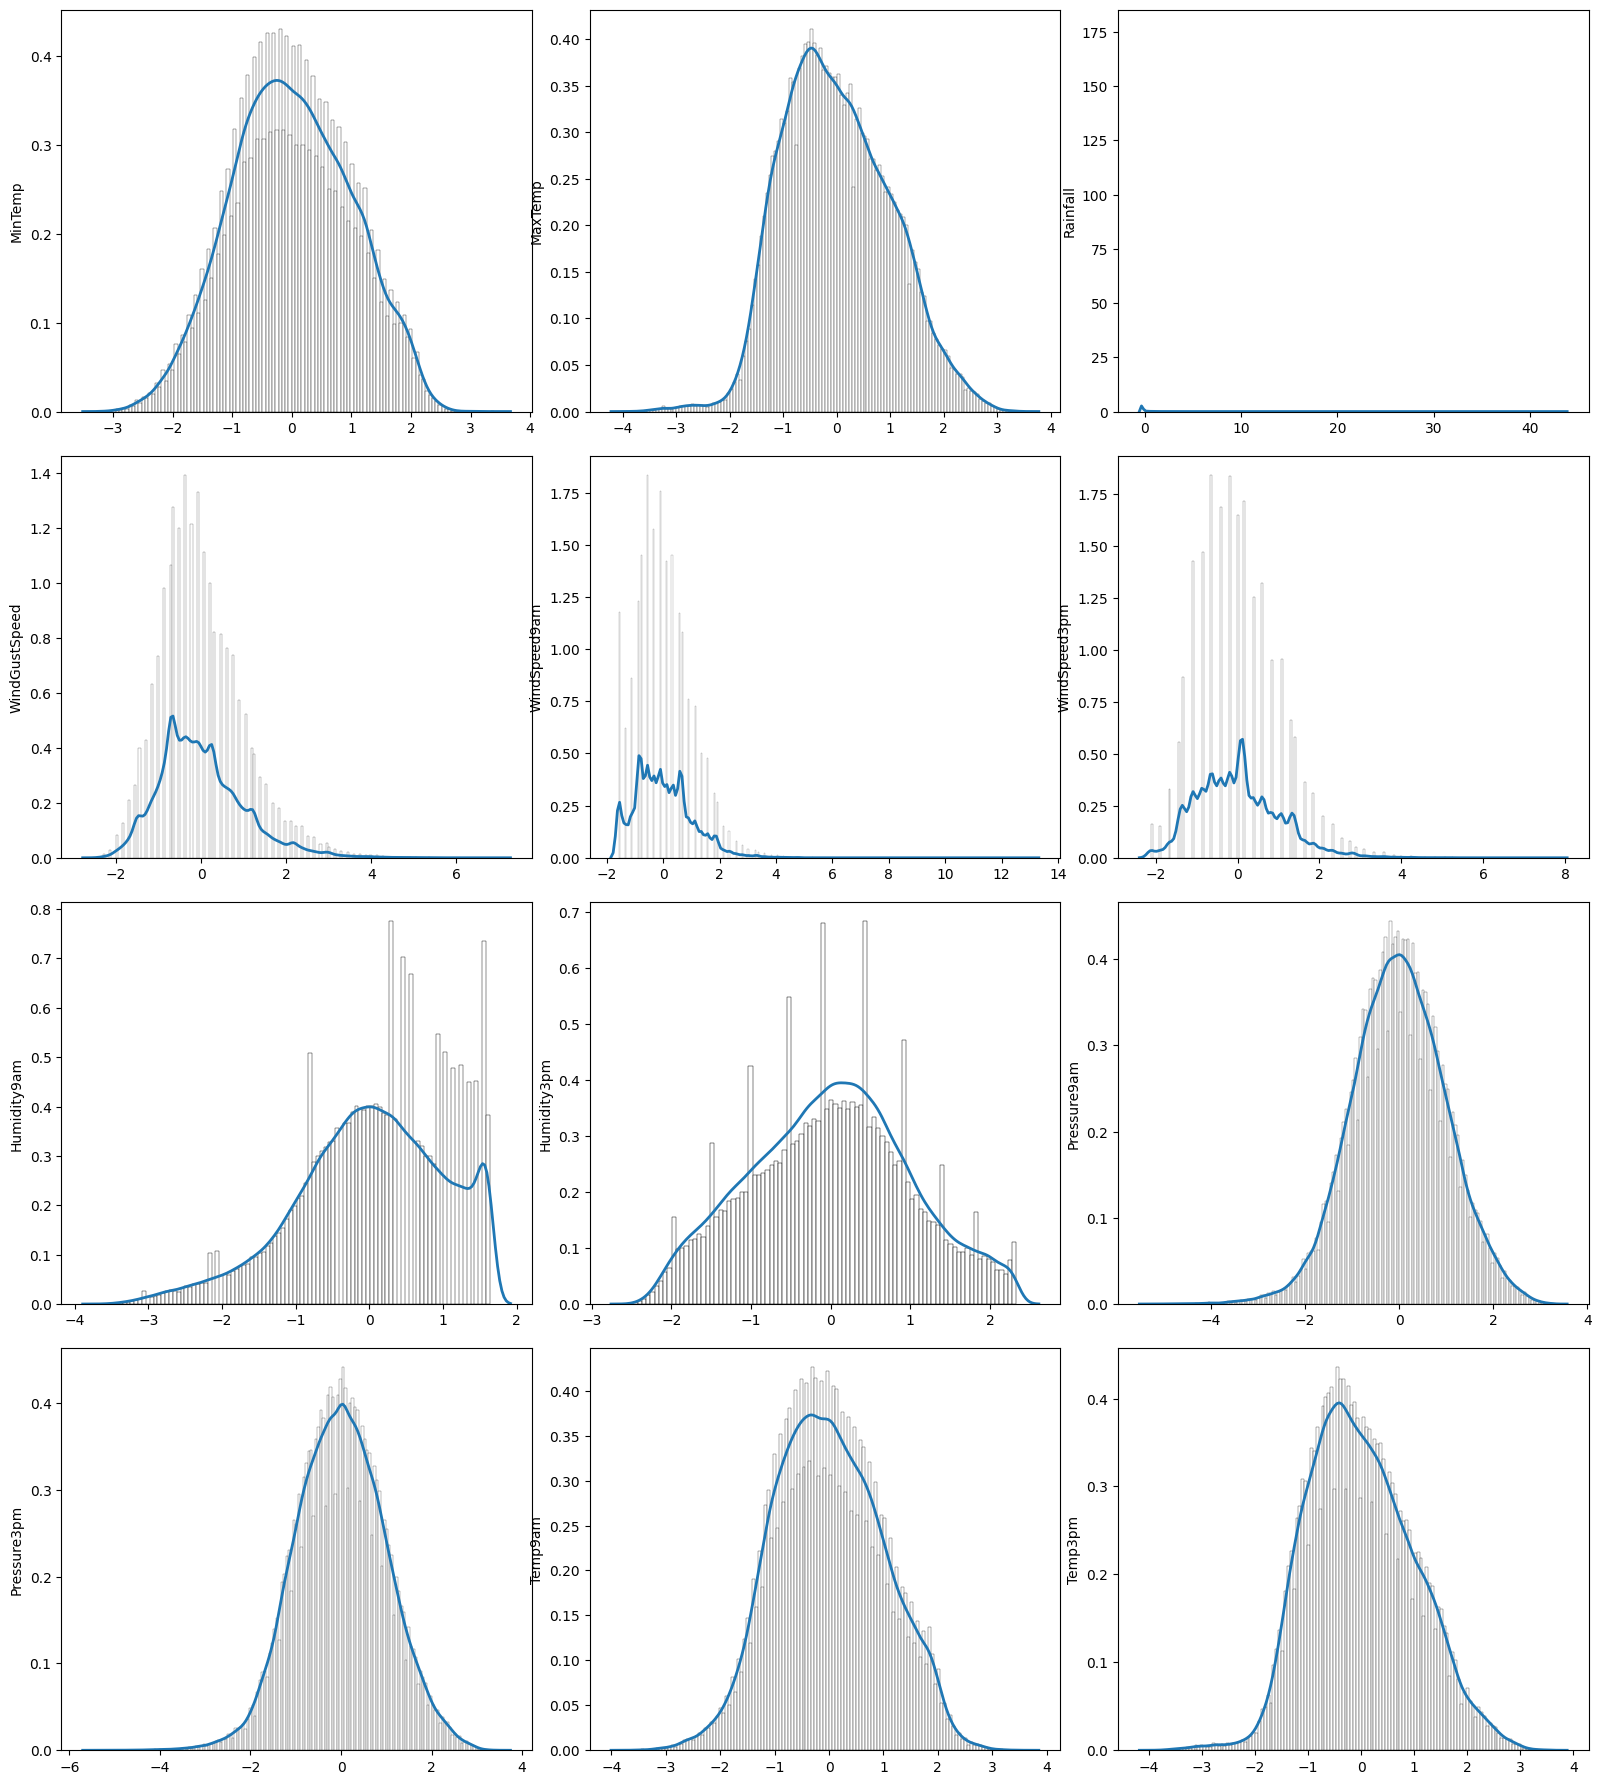

In [35]:
list_group = []

# Get every 3 features
for i in range(0, len(Numerical),3):
    list_group.append(Numerical[i:i+3])

fig, axs = plt.subplots(ncols=3, nrows = len(list_group), figsize=(16, 18))
fig.tight_layout()

cont = 0

# Loop over every 3 features
for pack in list_group:

    for i in range(len(pack)):
        #print(cont,i)
        column = pack[i] # Set col name

        sns.histplot(df_numerical[column], kde=False, stat='density', ax=axs[cont][i], color='white', edgecolor='black') # Histogram plot
        sns.kdeplot(df_numerical[column], ax=axs[cont][i], linewidth=2.0) # Density plot

        # Axis customization
        axs[cont][i].set_xlabel('')
        axs[cont][i].set_ylabel(column)
        #axs[cont][i].set_ylim(df[column].min() - abs(df[column].min()) * 0.1 , df[column].max() + df[column].max() * 0.1)

    cont+=1

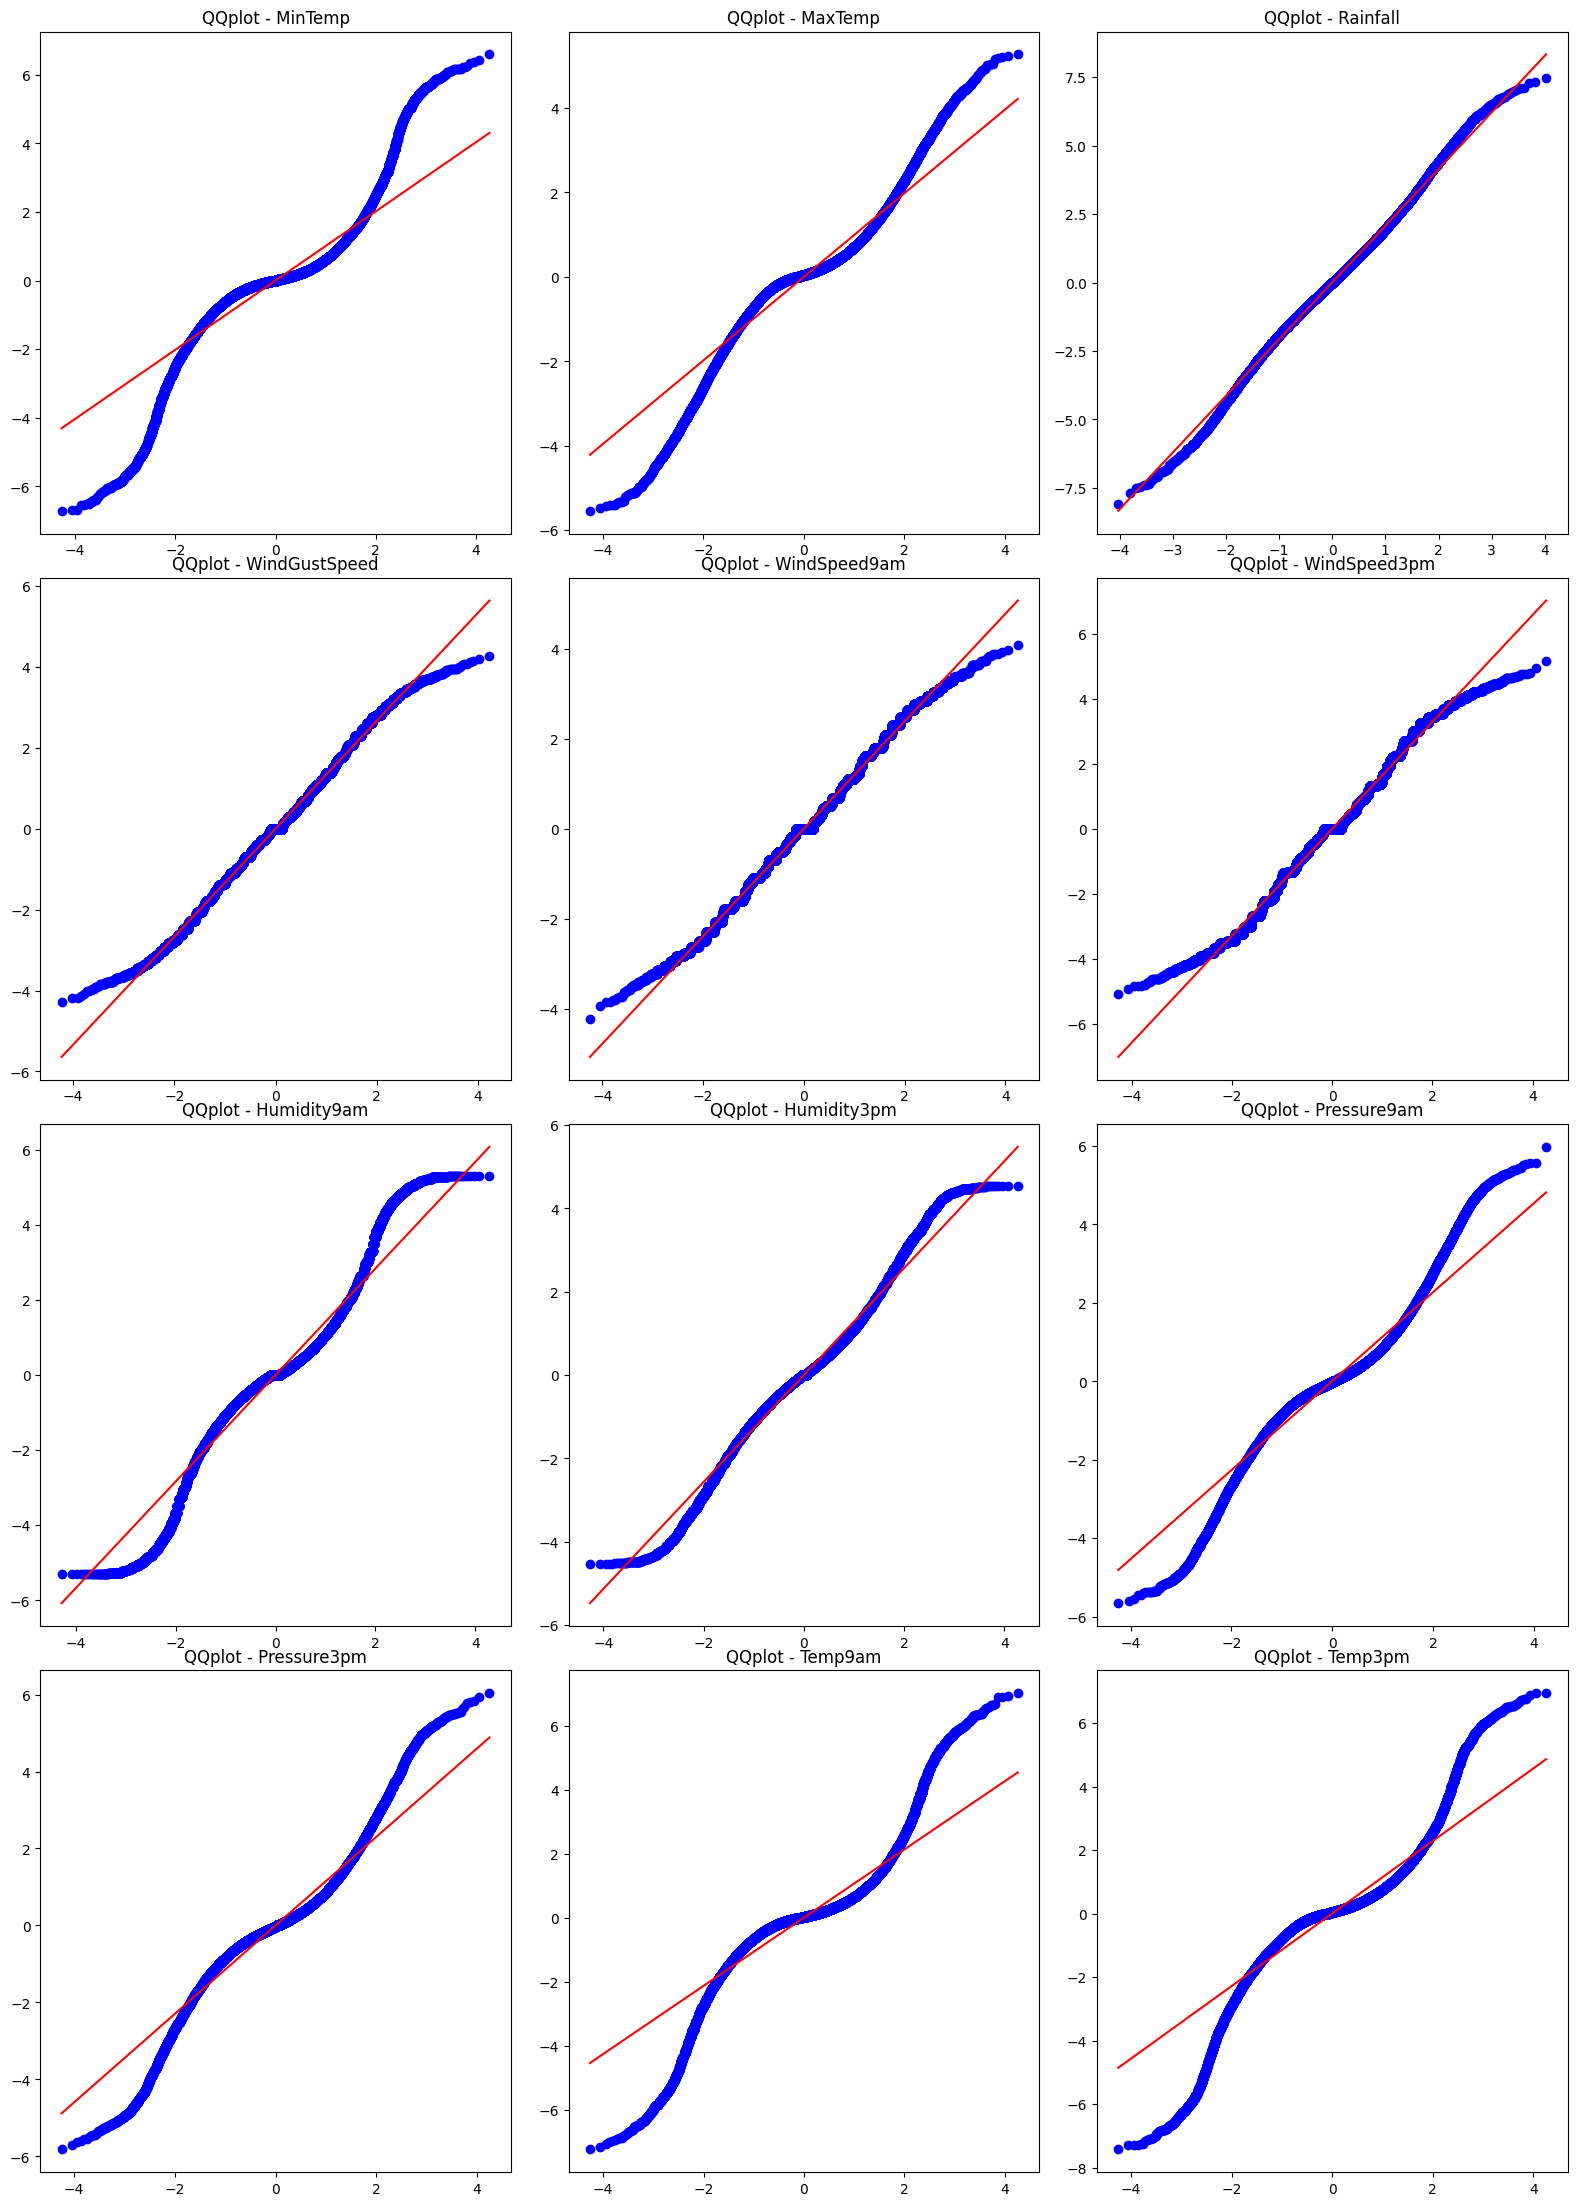

In [36]:
list_group = []

# Get every 3 features
for i in range(0, len(Numerical),3):
    list_group.append(Numerical[i:i+3])

fig, axs = plt.subplots(ncols=3, nrows = len(list_group), figsize=(16, 22))
fig.tight_layout()

cont = 0

# Loop over every 3 features
for pack in list_group:

    for i in range(len(pack)):
        col = pack[i] # Set col name

        col = df_numerical[col]
        col = np.diff(np.log(col[col>0]))

        stats.probplot(col,plot = axs[cont,i]) # Probplot

        # Axis customization
        axs[cont,i].set_title('QQplot - ' + pack[i])
        axs[cont,i].set_xlabel('')
        axs[cont,i].set_ylabel('')

    cont+=1


In [37]:
import random

random.seed(42)

# Fill the missing values with the median
for col in Numerical:

  df.loc[(df[col].isnull()) & (df['RainTomorrow'] == 'Yes'), col] = df[df['RainTomorrow'] == 'Yes'][col].median()
  df.loc[(df[col].isnull()) & (df['RainTomorrow'] == 'No'), col] = df[df['RainTomorrow'] == 'No'][col].median()


In [38]:
round((df[Numerical].isnull().sum() / df.shape[0]) * 100,2) # Show the remaining missing values

MinTemp          0.0
MaxTemp          0.0
Rainfall         0.0
WindGustSpeed    0.0
WindSpeed9am     0.0
WindSpeed3pm     0.0
Humidity9am      0.0
Humidity3pm      0.0
Pressure9am      0.0
Pressure3pm      0.0
Temp9am          0.0
Temp3pm          0.0
dtype: float64

## Data Correlation & Engineering

* We can observe that temperature features are highly positively correlated.

* MaxTemp and Temp3pm are positively correlated (coeff. 0.97).

* MinTemp and Temp9am are positively correlated (coeff. 0.90).

* MaxTemp and Temp9am are positively correlated (coeff. 0.88).

* Temp9am and Temp3pm are positively correlated (coeff. 0.85).

* Also Pressure9am and Pressure3pm are positively correlated (coeff. 0.96).

* Based on the correlation features and the previous density plots, we decided to combine all the high related features.



<Axes: >

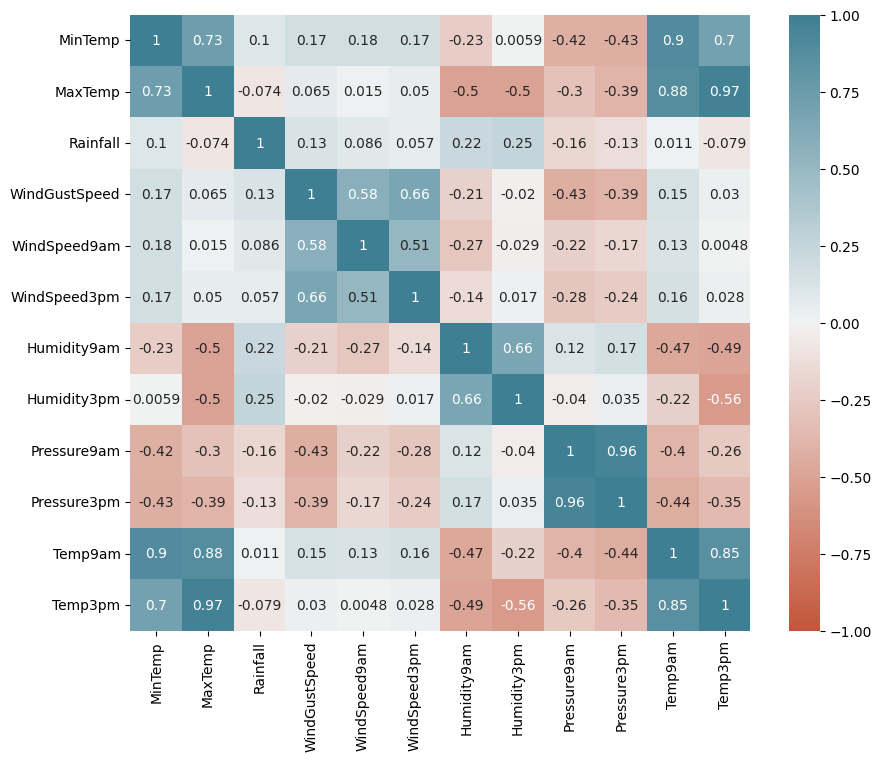

In [39]:
# Plot correlation coefficient
fig = plt.figure(figsize = (10,8))

sns.heatmap(df[Numerical].corr(), vmin = -1, vmax = 1,
            cmap = sns.diverging_palette(20, 220, as_cmap = True),
            annot = True)

In [40]:
# Create new features based on the mean on the high correlated features

# Select the min temperature of the day
df['NewTemp'] = df[['MaxTemp', 'MinTemp', 'Temp3pm', 'Temp9am']].min(axis = 1)

# Select pressure variation
df['NewPressure'] = df['Pressure9am'] - df['Pressure3pm']

# Calculate the mean WindSpeed
df['NewWind'] = df[['WindGustSpeed', 'WindSpeed3pm', 'WindSpeed9am']].sum(axis = 1) / 3

# Calculate the max Humidity
df['NewHumidity'] = df[['Humidity9am', 'Humidity3pm']].max(axis = 1)

# New numerical features
Numerical = ['NewTemp','NewPressure', 'NewWind', 'NewHumidity', 'Rainfall']

## Data Transformation & Balance

* First of all, we scaled the numerical data to reduce the impact of outliers or scales.

* Then we apply a hot encoder to the categorical features, because they are ordinal data, i.e. they do not have a hierarchy.

* As we observed in the previous sections, the RainTomorrow feature is imabalanced. Therefore, we drop 60% of the 'No' RainTomorrow datapoints to balance the train data.

In [41]:
# Concat the data and apply a one hot encoder to the categorical data

data = pd.concat([df.reset_index()[Numerical],
               pd.get_dummies(df.reset_index().Location, dtype = int),
               pd.get_dummies(df.reset_index().WindGustDir, dtype = int),
               #pd.get_dummies(df.reset_index().WindDir9am, dtype = int),
               #pd.get_dummies(df.reset_index().WindDir3pm, dtype = int),
               pd.get_dummies(df.reset_index().RainToday, dtype = int),
               df.reset_index()['RainTomorrow']], axis = 1)

# Econding the target feature
data.loc[data['RainTomorrow'] == 'No', 'RainTomorrow'] = 0
data.loc[data['RainTomorrow'] == 'Yes', 'RainTomorrow'] = 1

data['RainTomorrow'] = data['RainTomorrow'].astype(int) # Set dtype to int

data.head()

,NewTemp,NewPressure,NewWind,NewHumidity,Rainfall,Adelaide,Albany,Albury,AliceSprings,BadgerysCreek,...,SE,SSE,SSW,SW,W,WNW,WSW,No,Yes,RainTomorrow
0,13.4,0.6,29.333333,71.0,0.6,0,0,1,0,0,...,0,0,0,0,1,0,0,1,0,0
1,7.4,2.8,23.333333,44.0,0.0,0,0,1,0,0,...,0,0,0,0,0,1,0,1,0,0
2,12.9,-1.1,30.333333,38.0,0.0,0,0,1,0,0,...,0,0,0,0,0,0,1,1,0,0
3,9.2,4.8,14.666667,45.0,0.0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,17.5,4.8,22.666667,82.0,1.0,0,0,1,0,0,...,0,0,0,0,1,0,0,1,0,0


In [42]:
from sklearn.preprocessing import StandardScaler

#data = data.drop(data.query('RainTomorrow == 0').sample(frac=.6).index)

X = data.drop(['RainTomorrow'], axis = 1)
Y = data['RainTomorrow']

# Scaling data
scaler = StandardScaler()
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X),columns= X.columns )

In [43]:
from sklearn.model_selection import train_test_split

# Split the data into train, test and validation
X_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)
X_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 42)

In [44]:
# Get the indices with value 0
zero_indices = y_train[y_train == 0].index

# Get a fraction of the indices
sample_indices = zero_indices.to_series().sample(frac=0.5, random_state=42).index

# Drop the indices from the train data
y_train = y_train.drop(sample_indices)
X_train = X_train.drop(sample_indices)

# Naive Model

* We first try to predict if it rains tomorrow based in the RainToday feature, i.e if RainToday is 1 then RainTomorrow is 1 and vice versa.

* The naive model presents a test accuracy score of 0.75, while the test precision and recall for the 'Yes' RainTomorrow categorie is 0.45.

In [105]:
from sklearn.metrics import accuracy_score

y_pred = pd.DataFrame(x_test['Yes']).applymap(lambda x: 1 if x > 0 else 0)

# Calculate the train accuracy score
print('Accuracy: ', accuracy_score(y_test,y_pred))

Accuracy:  0.7573402721614684


In [106]:
from sklearn.metrics import classification_report

#Get classification report based on test data
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.84      0.85      0.84     22098
           1       0.45      0.45      0.45      6341

    accuracy                           0.76     28439
   macro avg       0.65      0.65      0.65     28439
weighted avg       0.76      0.76      0.76     28439



# Loggistic Regression Model

* The model selected was a Loggistic Regression, to determine the data point probability of belong to a class.

* The model was train with the 70% of the data.

* After training we did a threshold analysis for the training data, where we observed that the threshold with the best training accuracy performance is 0.5.

* The precision and recall of the interest categorie are 0.71 and 0.6 respectively.

In [45]:
from sklearn.linear_model import LogisticRegression

# Define and train a LogisticRegression model
logreg = LogisticRegression( random_state = 42)

logreg.fit(X_train, y_train)

LogisticRegression(random_state=42)

Best threshold is  0.5 :  0.7655158109703564


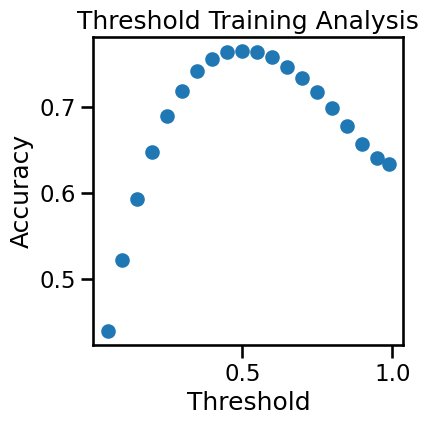

In [91]:
from sklearn.metrics import accuracy_score

threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]

accuracy = []

for th in threshold_list:

  y_pred = pd.DataFrame(logreg.predict_proba(X_train))

  y_pred = y_pred.applymap(lambda x: 1 if x > th else 0)[1]

  # Calculate the train accuracy score
  accuracy.append(accuracy_score(y_train,y_pred))

fig, ax = plt.subplots(figsize = (4,4))

plt.scatter(x = threshold_list, y = accuracy)

ax.set_xlabel('Threshold')
ax.set_ylabel('Accuracy')
plt.title('Threshold Training Analysis')

print('Best threshold is ', threshold_list[accuracy.index(max(accuracy))], ': ', max(accuracy))

In [60]:
from sklearn.metrics import accuracy_score

# Calculate the train accuracy score
y_pred = logreg.predict(X_train)
print('Accuracy: ', accuracy_score(y_train,y_pred))

Accuracy:  0.7655158109703564


In [47]:
from sklearn.metrics import classification_report

#Get classification report based on test data
cr = classification_report(y_train, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.79      0.86      0.82     39699
           1       0.71      0.60      0.65     22979

    accuracy                           0.77     62678
   macro avg       0.75      0.73      0.74     62678
weighted avg       0.76      0.77      0.76     62678



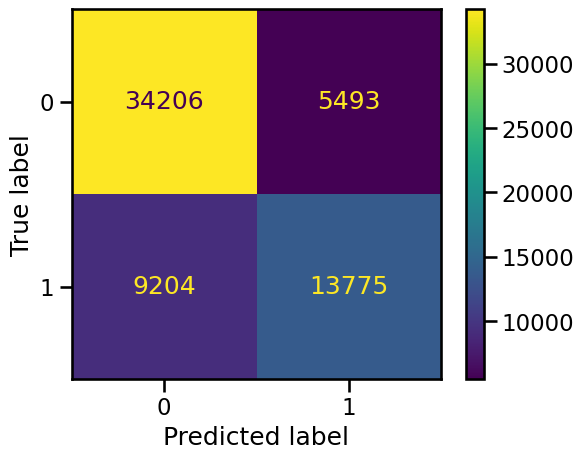

In [48]:
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix,ConfusionMatrixDisplay

#Plot the confussion matrix of the test and predict data
sns.set_context('talk')
cm = confusion_matrix(y_train, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=logreg.classes_)
disp.plot()
plt.show()

## Validation Results

* We observed that the best threshold for the validation set is 0.65 in terms of accuracy, but this threshold present a worse precision and recall metrics for the interest categorie.

* Therefore, we decide to keep the threshold in 0.5, because the precision and recall of the interest categorie are above 0.5.

Best threshold is  0.65 :  0.8241912798874824


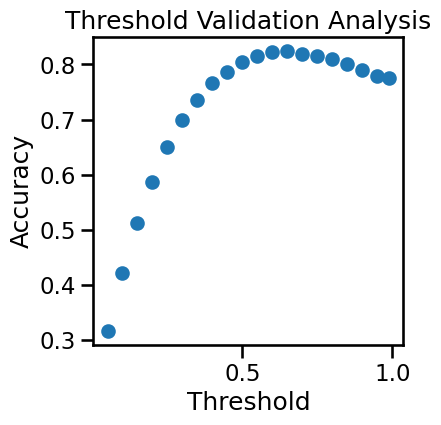

In [84]:
from sklearn.metrics import accuracy_score

threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]

accuracy = []

for th in threshold_list:

  y_pred = pd.DataFrame(logreg.predict_proba(x_val))

  y_pred = y_pred.applymap(lambda x: 1 if x > th else 0)[1]

  # Calculate the train accuracy score
  accuracy.append(accuracy_score(y_val,y_pred))

fig, ax = plt.subplots(figsize = (4,4))

plt.scatter(x = threshold_list, y = accuracy)

ax.set_xlabel('Threshold')
ax.set_ylabel('Accuracy')
plt.title('Threshold Validation Analysis')

print('Best threshold is ', threshold_list[accuracy.index(max(accuracy))], ': ', max(accuracy))

In [119]:
from sklearn.metrics import accuracy_score

th = 0.5

y_pred = pd.DataFrame(logreg.predict_proba(x_val))
y_pred = y_pred.applymap(lambda x: 1 if x > th else 0)[1]

print('Accuracy: ', accuracy_score(y_val,y_pred))

Accuracy:  0.8044127988748242


In [120]:
from sklearn.metrics import classification_report

#Get classification report based on test data
cr = classification_report(y_val, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.88      0.86      0.87      8819
           1       0.56      0.61      0.58      2557

    accuracy                           0.80     11376
   macro avg       0.72      0.74      0.73     11376
weighted avg       0.81      0.80      0.81     11376



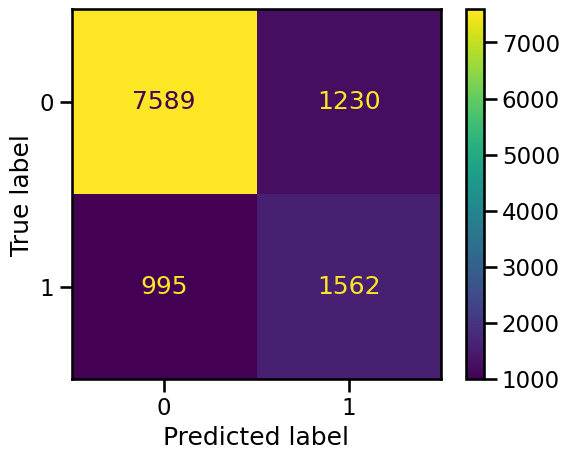

In [121]:
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix,ConfusionMatrixDisplay

#Plot the confussion matrix of the test and predict data
sns.set_context('talk')
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=logreg.classes_)
disp.plot()
# plt.show()

## Test Results

* Finally, we can observed that the logistic regression model present a better accuracy than the naive model, almost 5% higher.

* While the precision metric is 10% higher and the recall metric is 15% higher. So we can say that the logistic regression model is better than the naive model.

In [ ]:
from sklearn.metrics import accuracy_score

y_pred = logreg.predict(x_test)

print('Accuracy: ', accuracy_score(y_test,y_pred))

Accuracy:  0.8023488870916698


In [ ]:
from sklearn.metrics import classification_report

#Get classification report based on test data
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.88      0.86      0.87     22098
           1       0.55      0.60      0.58      6341

    accuracy                           0.80     28439
   macro avg       0.72      0.73      0.72     28439
weighted avg       0.81      0.80      0.81     28439



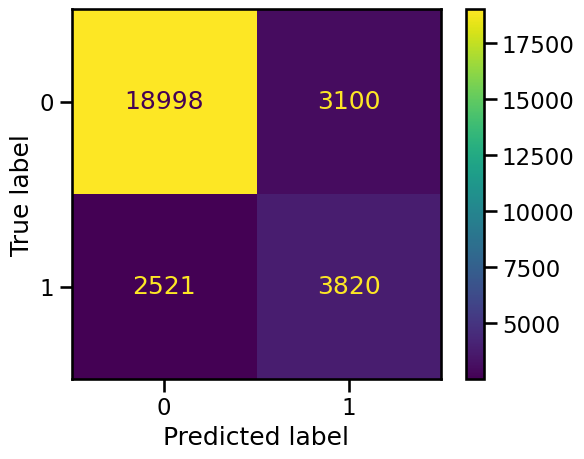

In [ ]:
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix,ConfusionMatrixDisplay

#Plot the confussion matrix of the test and predict data
sns.set_context('talk')
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=logreg.classes_)
disp.plot()
plt.show()